# Models, Simulations, Tables and Plots

This script computes the simulations and associated moments of several version of the model, with and without self-fulfilling shocks, with short and long debt, and with the floating rate bond.

In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__, "..")); Pkg.instantiate()

using Revise
using LTBonds
using Random 
using PrettyTables
using Plots
using LaTeXStrings

  Activating project at `~/Github/floating_rate`


In [2]:
SAVE_MOMENTS = true # set to true to save the moments to file. 
SAVE_FIGS = true 

true

# Models

In [3]:
benchmark_parameters =  let
    R = 1.01
    β = 0.9540232420
    pref = Preferences(β = β, u = make_CRRA(ra = 2))
    y = discretize(YProcess(n = 50, ρ = 0.948503, std = 0.027092, μ = 0.0, span = 3.0, tails = false))
    m = MTruncatedNormal(; std = 0.01, span = 2.0, quadN = 100)
    penalty = DefCosts(pen1 = -0.1881927550, pen2 = 0.2455843389, quadratic = true, reentry = 0.0385)
    η=0.1

    (R = R, pref = pref, y = y, m = m, penalty = penalty, η = η)
end;

In [4]:
models = let
    R, pref, y, m, penalty, η = benchmark_parameters

    bondFR = FloatingRateBond(;n = 350, min = 0.0, max = 1.5, λ = 0.05, κbar = 0.06) 
    bondFRlowκ = FloatingRateBond(;n = 350, min = 0.0, max = 1.5, λ = 0.05, κbar = 0.015) 
    bondLT = Bond(n = 350, min = 0.0, max = 1.5, κ = R - 1, λ = 0.05)  
    bondST = Bond(n = 350, min = 0.0, max = 1.5, κ = R - 1, λ = 1.0)  
    
    fr = generate_workspace(
        CKLTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondFR, 
            def_costs = penalty, 
            R = R,
            η = η
        )
    )

    frlowκ = generate_workspace(
        CKLTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondFRlowκ, 
            def_costs = penalty, 
            R = R,
            η = η
        )
    )   

    egLT = generate_workspace(
        LTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondLT, 
            def_costs = penalty, 
            R = R,
        )
    )

    ckLT = generate_workspace(
        CKLTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondLT, 
            def_costs = penalty, 
            R = R,
            η = η
        )
    )

    egST = generate_workspace(
        LTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondST, 
            def_costs = penalty, 
            R = R,
        )
    )

    ckST = generate_workspace(
        CKLTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondST, 
            def_costs = penalty, 
            R = R,
            η = η
        )
    )


    (; fr, frlowκ, egLT, ckLT, egST, ckST) 
end;

In [5]:
@time for m ∈ models
    @time solve!(m; print_every = 200, max_iters = 5_000, err = 1e-7)
end

1: (v = 1.4304966712931169, κ = 0.04999999999999999, q = 0.6091402083520817, vD = 0.5336647908767098)
201: (v = 0.009426288264176463, κ = 0.0021488574675934125, q = 0.016999073119353558, vD = 8.440532472420159e-5)
401: (v = 1.4446863652040065e-6, κ = 9.347770661971566e-7, q = 4.3295385609987136e-7, vD = 6.844129885053007e-8)
476: (v = 9.712389825722312e-8, κ = 6.32519816523569e-8, q = 2.5087102617504797e-8, vD = 4.064144576432227e-9)
Converged.
203.896910 seconds (22.76 M allocations: 1.348 GiB, 0.23% gc time, 8.03% compilation time)
1: (v = 1.4304966712931169, κ = 0.0049999999999999906, q = 0.6091402083520817, vD = 0.5336647908767098)
201: (v = 0.0004991181069833317, κ = 0.00024817102644680844, q = 0.0016605596415601998, vD = 0.00015718183862034607)
401: (v = 1.0532920526884482e-6, κ = 3.019461456421624e-7, q = 3.5933910167429417e-6, vD = 4.917473646059989e-7)
509: (v = 2.9510079713190862e-8, κ = 8.281826335831965e-9, q = 9.825578395350476e-8, vD = 1.4167724771141366e-8)
Converged.
21

# Simulations

In [6]:
big_T = 20_000 
big_N = 1_000

1000

In [7]:
computed_moments = let 
    rng = Random.seed!(1234)
    shocks, paths = create_shocks_paths(models.ckLT, big_T, big_N; rng) # make sure to use a ck model to draw the sunspots
    map(
        (; models.fr, models.egST, models.ckST, models.egLT, models.ckLT, models.frlowκ)) do (m) 
        simulation!(paths, shocks, m; n = big_T, trim = 1000, trim_def = 20)
        out = moments(paths, m)
        (; out.mean_bp_y, out.mean_mv_y, out.def_rate, out.mean_spread, out.std_spread, out.mean_κ, out.std_κ, out.run_share)
    end
end;

In [8]:
pretty_table(
    collect(map(m -> pairs(m), computed_moments)),
    row_names = collect(keys(computed_moments)), 
    backend = Val(:html),
    formatters = ( ft_printf("%5.2f", [1, 2]), ft_printf("%5.3f"))
)

,mean_bp_y,mean_mv_y,def_rate,mean_spread,std_spread,mean_κ,std_κ,run_share
fr,0.82,0.82,0.003,0.003,0.005,0.011,0.001,0.087
egST,0.82,0.82,0.003,0.003,0.004,0.010,0.000,0.000
ckST,0.38,0.37,0.002,0.002,0.003,0.010,0.000,1.000
egLT,0.94,0.72,0.067,0.080,0.044,0.010,0.000,0.000
ckLT,0.94,0.72,0.067,0.080,0.044,0.010,0.000,0.003
frlowκ,0.87,0.78,0.033,0.038,0.029,0.011,0.002,0.003


In [9]:
SAVE_MOMENTS && open(joinpath(@__DIR__,"..","output","moments.txt"), "w") do f
    pretty_table(f, 
        collect(map(m -> pairs(m), computed_moments)),
        row_names = collect(keys(computed_moments)), 
        formatters = ( ft_printf("%5.2f", [1, 2]), ft_printf("%5.3f"))
    )
end

## Plots

In [10]:
#set linewidth for plots:
lw = 2
ms = 3
msdiamond = 5
default(size = (600, 400), xtickfontsize = 12, ytickfontsize = 12, yguidefontsize = 14, xguidefontsize = 14)

In [11]:
###Value at zero debt plots###
midY = length(get_y_grid(models.fr)) ÷ 2
ygrid = get_y_grid(models.fr);

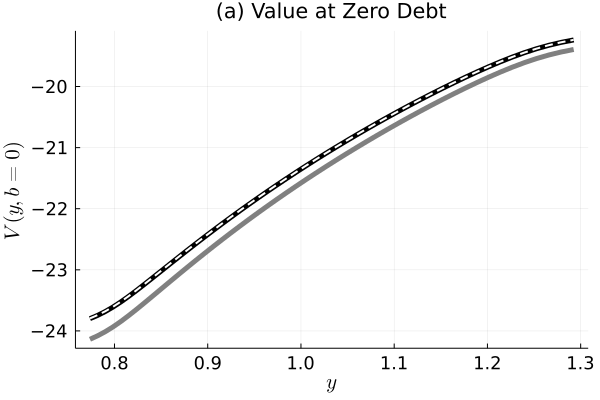

In [12]:
f1 = plot(ygrid, get_v(models.fr)[1,:,midY], line = (5, :black), legend = false, xlabel = (L"$y$"),
        ylabel = (L"$V(y,b=0)$"), title = "(a) Value at Zero Debt")
plot!(f1, ygrid, get_v(models.ckST)[1,:] , line = (5, :grey))
plot!(f1, ygrid, get_v(models.egST)[1,:] , line = (lw, :white, :dash))
f1

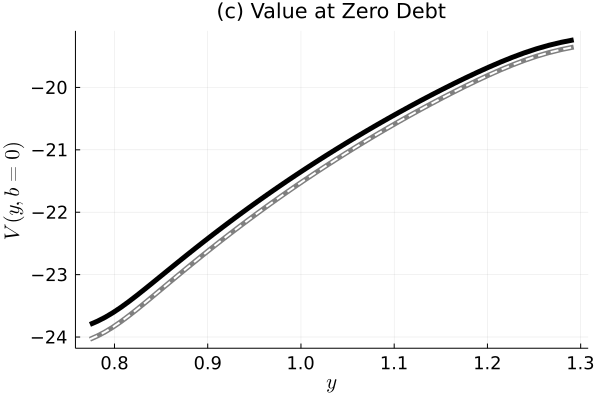

In [13]:
f2 = plot(ygrid, get_v(models.fr)[1,:,midY], line = (5, :black), legend=false,
        xlabel = (L"$y$"), ylabel = (L"$V(y,b=0)$"), title = "(c) Value at Zero Debt")
plot!(f2, ygrid, get_v(models.ckLT)[1,:] , line = (5, :grey))
plot!(f2, ygrid, get_v(models.egLT)[1,:] , line = (lw, :white, :dash))
f2

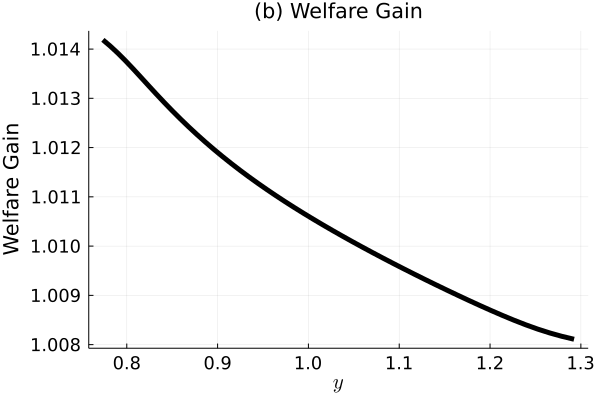

In [14]:
welfareST = [
    inv_u.(Ref(get_u(models.fr)), get_v(models.fr)[1, i, 1]) ./ 
    inv_u.(Ref(get_u(models.ckST)), get_v(models.ckST)[1,i]) for i = 1:length(-get_v(models.fr)[1, :, 1])];

f3 = plot(ygrid, welfareST, line=(5, :black), legend = false, xlabel = L"$y$",
        ylabel = "Welfare Gain", title = "(b) Welfare Gain")
f3

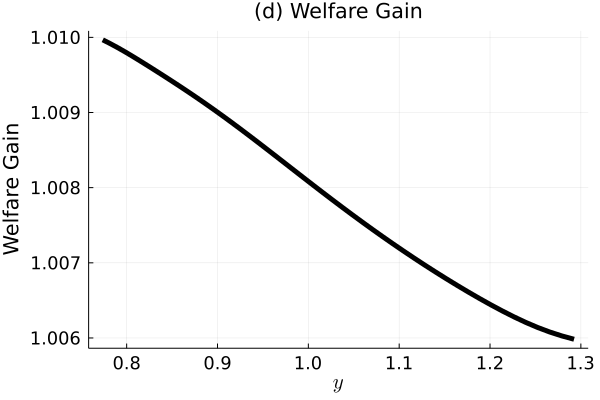

In [15]:
welfareLT = [
    inv_u.(Ref(get_u(models.fr)), get_v(models.fr)[1, i, 1]) ./ 
    inv_u.(Ref(get_u(models.ckLT)), get_v(models.ckLT)[1,i]) for i = 1:length(-get_v(models.fr)[1, :, 1])]

f4 = plot(ygrid, welfareLT, line = (5, :black), legend = false, xlabel = L"$y$",
    ylabel = "Welfare Gain", title = "(d) Welfare Gain")
f4

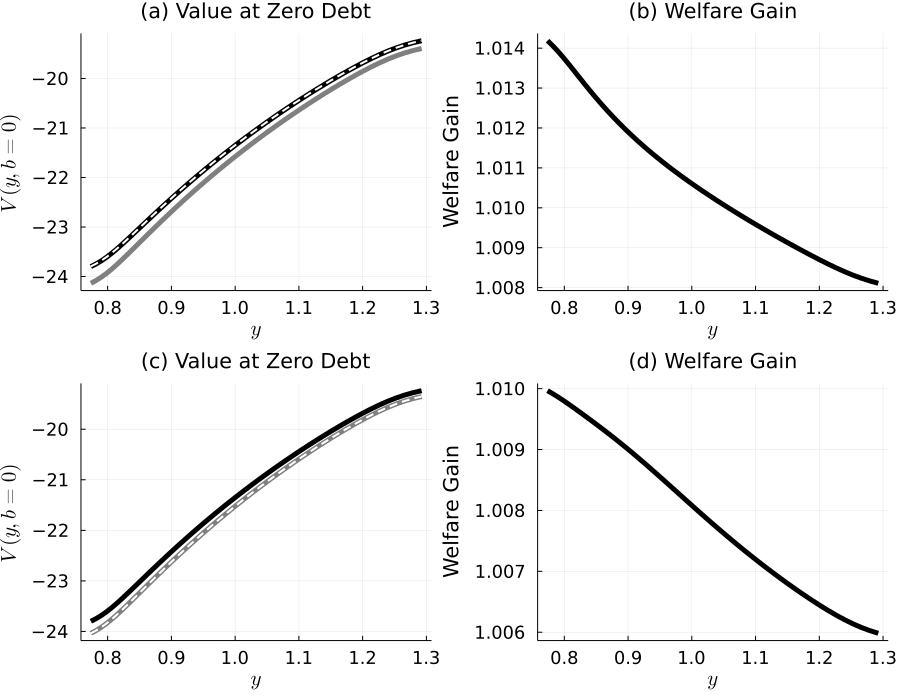

In [16]:
figure2 = plot(f1, f3, f2, f4, size= (900, 700))

### Pareto Frontiers

In [17]:
_get_frontier_y_state(::AbstractFixedRateBond, yi, lag_y) = (yi, )
_get_frontier_y_state(::AbstractFloatingRateBond, yi, lag_y) = (yi, lag_y)
_get_frontier_κ(bond::AbstractFixedRateBond, _, _, _) = get_κ(bond)
_get_frontier_κ(::AbstractFloatingRateBond, m, bi, lag_y) = m.current.κ[bi, lag_y]
_get_frontier_mv(bond::AbstractFixedRateBond, q, b, _) = find_bond_return(bond; q) * b
_get_frontier_mv(bond::AbstractFloatingRateBond, q, b, κ) = find_bond_return(bond; q, κ) * b

get_frontier(m, yi; kwargs...) = get_frontier(get_bond(m), m, yi; kwargs...)

function get_frontier(bond, m::LTBonds.WorkSpace, yi; lag_y = midY)
    bgrid = get_b_grid(m)
    λ = get_λ(bond)
    mv = []
    v = []
    y_state = _get_frontier_y_state(bond, yi, lag_y)
    for bi = 1:length(bgrid)
        default = m.policies.d[bi, y_state...] == m.model.m.m_min
        biprime = get_b_pol(m)[bi, y_state...][end, 1].idx
        q = get_q(m)[biprime, yi]
        κ = _get_frontier_κ(bond, m, bi, lag_y)
        b = get_b_grid(m)[bi]
        push!(mv, (1 - default) * _get_frontier_mv(bond, q, b, κ))
        push!(v, (1 - default) * get_v(m)[bi, y_state...] + default * get_vD(m)[yi])
    end
    return v, mv
end
;

In [18]:
markerevery(series; n = 1) = collect(view(series, 1:n:length(series)))

markerevery (generic function with 1 method)

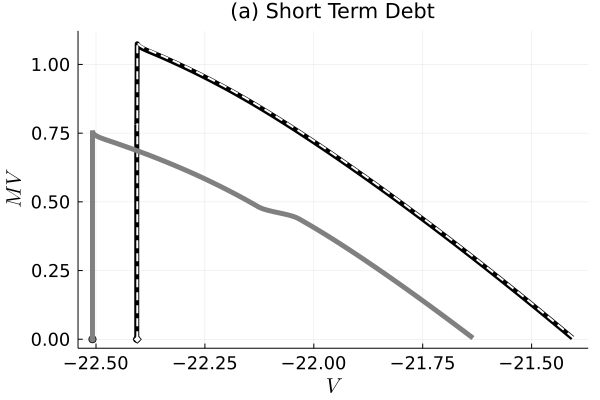

In [19]:
f3a = let 
    m = models.fr
    vD = get_vD(m)[midY]
    frontier = get_frontier(m, midY)
    xx = [x  for x in zip(frontier[1], frontier[2]) if x[1] > vD && x[2] > 0]
    f = plot([x[1] for x in xx], [x[2] for x in xx], 
        line=(5, :black), legend=false, xlabel=(L"$V$"), ylabel=(L"MV")
    )
    plot!(f, [vD], [0], marker = 4, markercolor=:black)
    plot!(f, [vD, xx[end][1]], [0, xx[end][2]], line = (5, :black))

    m = models.egST
    vD = get_vD(m)[midY]
    frontier = get_frontier(m, midY)
    xx = [x  for x in zip(frontier[1], frontier[2]) if x[1] > vD && x[2] > 0]
    plot!(f, [x[1] for x in xx], [x[2] for x in xx], 
        line=(lw, :white, :dash))
    # xx_f = markerevery(xx; n = 10)
    # scatter!(f, [x[1] for x in xx_f], [x[2] for x in xx_f], 
    #     markershape=:diamond,markercolor=:blue)
    plot!(f, [vD], [0], markershape=:diamond, marker = 4,markercolor=:white)
    plot!(f, [vD, xx[end][1]], [0, xx[end][2]], line=(lw, :white, :dash))

    m = models.ckST
    vD = get_vD(m)[midY]
    frontier = get_frontier(m, midY)
    xx = [x  for x in zip(frontier[1], frontier[2]) if x[1] > vD && x[2] > 0]
    plot!(f, [x[1] for x in xx], [x[2] for x in xx], 
        line=(5, :grey))
    # xx_f = markerevery(xx; n = 15)
    # scatter!(f, [x[1] for x in xx_f], [x[2] for x in xx_f], 
    #     markershape=:circle,markercolor=:red)
    plot!(f, [vD], [0], markershape=:circle, marker = 4,markercolor=:grey)
    plot!(f, [vD, xx[end][1]], [0, xx[end][2]], line=(5, :grey))
    plot!(f, title = "(a) Short Term Debt")
    f
end 

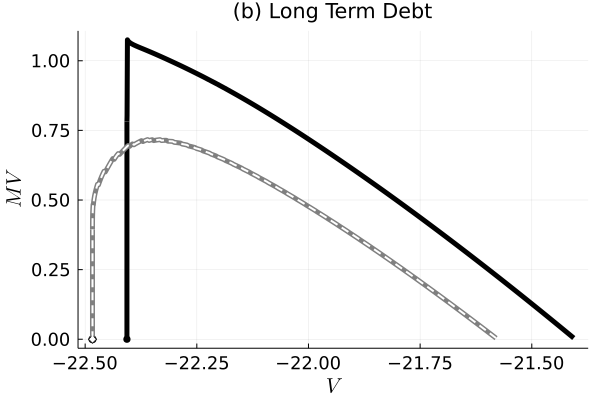

In [20]:
f3b = let 
    m = models.fr
    vD = get_vD(m)[midY]
    frontier = get_frontier(m, midY)
    xx = [x  for x in zip(frontier[1], frontier[2]) if x[1] > vD && x[2] > 0]

    f = plot([x[1] for x in xx], [x[2] for x in xx], 
        line=(5, :black), legend=false, xlabel=(L"$V$"), ylabel=(L"MV")
    )
    plot!(f, [vD], [0], marker = 4, markercolor=:black)
    plot!(f, [vD, xx[end][1]], [0, xx[end][2]], line=(5, :black))

    m = models.ckLT
    vD = get_vD(m)[midY]
    frontier = get_frontier(m, midY)
    xx = [x  for x in zip(frontier[1], frontier[2]) if x[1] > vD && x[2] > 0]
    plot!(f, [x[1] for x in xx], [x[2] for x in xx], 
        line=(5, :grey))
    # xx_f = markerevery(xx; n = 15)
    # scatter!(f, [x[1] for x in xx_f], [x[2] for x in xx_f], 
    #     markershape=:circle, markercolor=:red)
    plot!(f, [vD], [0], markershape=:circle, marker = 4, markercolor=:grey)
    plot!(f, [vD, xx[end][1]], [0, xx[end][2]], line=(5, :grey))
    
    m = models.egLT
    vD = get_vD(m)[midY]
    frontier = get_frontier(m, midY)
    xx = [x  for x in zip(frontier[1], frontier[2]) if x[1] > vD && x[2] > 0]
    plot!(f, [x[1] for x in xx], [x[2] for x in xx], 
        line=(lw, :white, :dash))
    # xx_f = markerevery(xx; n = 10)
    # scatter!(f, [x[1] for x in xx_f], [x[2] for x in xx_f], 
    #     markershape=:diamond,markercolor=:blue)
    plot!(f, [vD], [0], markershape=:diamond, marker = 4,markercolor=:white)
    plot!(f, [vD, xx[end][1]], [0, xx[end][2]], line=(lw, :white, :dash))
    plot!(f, title = "(b) Long Term Debt")
    f
end 

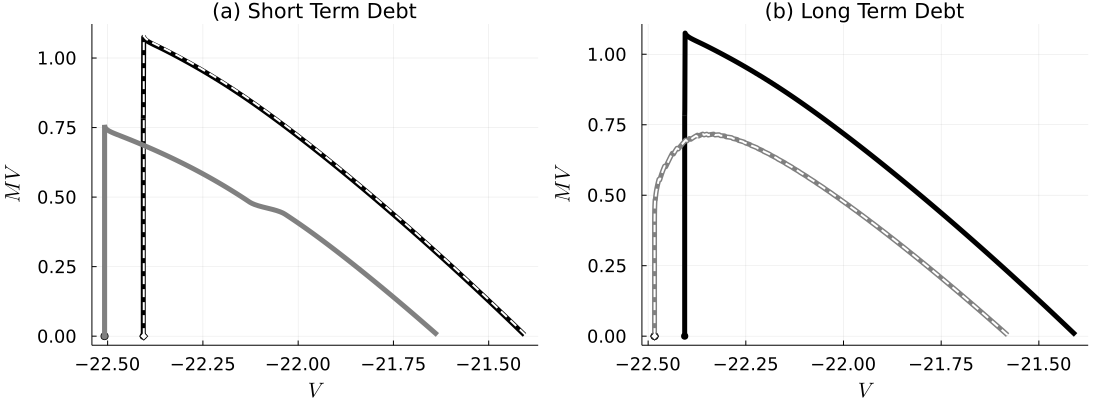

In [21]:
figure3 = plot(f3a, f3b, size = (1100, 400), left_margin = 5 * Plots.mm, bottom_margin = 5 * Plots.mm)

In [22]:
let 
    SAVE_FIGS && savefig(figure2, joinpath(@__DIR__, "..", "output", "figure2.pdf"))
    SAVE_FIGS && savefig(figure3, joinpath(@__DIR__, "..", "output", "figure3.pdf"))
end 